# Load Needed Packages

#### Note: if you want to change precision or device of JAX, the best way to do it is to follow (as an example)
#### `conda activate <your env name>`
#### `conda env config vars set JAX_ENABLE_X64=True`
#### `conda env config vars set jax_platform_name=cpu`
#### `conda activate <your env name>`
#### Make sure to restart VScode or jupyter notebook after this! `jax.config.update()` may or may not work because I define default jax arrays in different places.

In [1]:
import jax, torch
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jar
# jax.config.update('jax_platform_name', 'cuda')
# jax.config.update("jax_enable_x64", False)

import numpy as np
import models, utils, GWBFunctions, nf_dist
import LikelihoodCalculator as LC
from enterprise_extensions.model_utils import get_tspan
import pickle, json, os, corner, glob, random, copy, time, inspect
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines

plt.style.use('dark_background')
hist_settings = dict(
    bins = 40,
    histtype = 'step',
    lw = 3,
    density = True
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

/home/koonima/FAST/FLASH/GWBFunctions.py:11: UserWarning: The package `interpax` is needed for spline interpolation of ORF.
  warnings.warn("The package `interpax` is needed for spline interpolation of ORF.")


The fastshermanmorrison package is not found. The single pulsar analyses are much faster with the fast algorithm!
Optional mpi4py package is not installed.  MPI support is not available.


# Choose a data set

In [2]:
dsets = ['SIMG45', 'SIMG', 'GSIM', 'GSIMNULL', 'GSIMRED', 'SIMRed', 'SIMBase', 'NIMCast', '15SIM', '12p5', 'A4Cast', 'SIMNULL', 'NIMCast', '15yr', 'AJAXPaper', 'SIMCurn']

In [3]:
id = -3
cname = dsets[id]
cname

'15yr'

In [4]:
crn_bins = 5
Npulsars = 67
noise_dict = {}
# cname = names[0][0]
cname

'15yr'

In [5]:
if cname == '12p5':
    rr = 0
    with open(f'../Data/Pickle/channelized_12yr_v3_partim_DE438.pkl', 'rb') as fin:
        psrs = pickle.load(fin)
    psrlist = [psr.name for psr in psrs]
    with open(f'../Data/Pickle/channelized_12p5yr_v3_full_noisedict.json', 'r') as fin:
        nd = json.load(fin)
    for k, v in nd.items():
        if 'equad' in k:
            noise_dict.update({k.replace('equad','tnequad' ):v})
        else:
            noise_dict.update({k:v})
elif cname == '15yr':
    rr = 0
    with open(f'../Data/Pickle/v1p1_de440_pint_bipm2019.pkl', 'rb') as fin:
        psrs = pickle.load(fin)[:Npulsars]
    psrlist = [psr.name for psr in psrs]
    with open(f'../Data/Pickle/v1p1_all_dict.json', 'r') as fin:
        noise_dict = json.load(fin)
    inc_ecorr = True
    backend = 'backend'
    tnequad = False
    
else:
    rr = 2
    with open(f'../DEMO/Data/Pickle/{cname}/{rr}.pkl', 'rb') as fin:
        psrs = pickle.load(fin)
    len(psrs)
    psrlist = [psr.name for psr in psrs]
    for pname in psrlist:
        noise_dict.update({pname + '_efac': 1.0})
        noise_dict.update({pname + '_log10_t2equad': -np.inf})

# Step 1: Model Construction

## Frequency-bins

In [6]:
Tspan = get_tspan(psrs) # The time-span of the entire PTA
crn_bins = 5 # number of frequency-bins for the GWB
int_bins = 30 # number of frequency-bins for the non-GWB (IRN) red noise
assert int_bins >= crn_bins
f_intrin = jnp.arange(1/Tspan, (int_bins + 0.01)/Tspan, 1/Tspan) # an array of frequency-bins for the IRN process
f_common = f_intrin[:crn_bins] # an array of frequency-bins for the common process
renorm_const = 1 # the factor by which the units are going to change (divided by). Set it to `1` for no unit change (seconds), or let it be `1e9` (nano seconds)

## Model 1

In [7]:
chosen_psd_model1, chosen_orf_model1, gwb_helper_dictionary1 = utils.hd_spectrum(renorm_const=renorm_const,crn_bins=crn_bins, lower_halflog10_rho=-9, upper_halflog10_rho=-3.5)
gwb_helper_dictionary1

{'ordered_gwb_psd_model_params': array(['halflog10_rho'], dtype='<U13'),
 'varied_gwb_psd_params': ['halflog10_rho'],
 'gwb_psd_param_lower_lim': Array([-9., -9., -9., -9., -9.], dtype=float32),
 'gwb_psd_param_upper_lim': Array([-3.5, -3.5, -3.5, -3.5, -3.5], dtype=float32)}

In [8]:
o1 = models.UniformPrior(gwb_psd_func = chosen_psd_model1,
                orf_func = chosen_orf_model1,
                crn_bins = crn_bins,
                int_bins = int_bins,
                f_common = f_common, 
                f_intrin = f_intrin,
                df = 1/Tspan,
                Tspan = Tspan, 
                Npulsars = len(psrs),
                psr_pos = [psr.pos for psr in psrs],
                gwb_helper_dictionary = gwb_helper_dictionary1,
                gamma_min = 0,
                gamma_max = 7,
                log10A_min = -20 + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                log10A_max = -11 + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                renorm_const = renorm_const)

In [9]:
def astro_prior_func_uniform(xs):
    '''
    this function does not do anything. Uniform prior is already included in the Bayesian inference object. 
    So, if you wish to use uniform prior on the astro parameters, this function is what you need.

    :param xs: an array of length equal to the number of astro params
    '''
    return 0
astro_prior_bounds = np.array([[0.1, 11.0], 
          [-3.5, -1.5], 
          [10.5, 12.5], 
          [7.6, 9.0], 
          [0.0, 0.9], 
          [-1.5, 0.0]])

astro_x0 = np.random.uniform( 
            astro_prior_bounds[:, 0], 
            astro_prior_bounds[:, 1])[None]
astro_x0, astro_x0.shape

(array([[ 4.57506897e+00, -3.32627940e+00,  1.16764147e+01,
          7.89285350e+00,  8.84877575e-01, -4.04996640e-03]]),
 (1, 6))

In [10]:
nf, half_range, B, mean, _, _ = torch.load('../Data/AstroData/PaperFinal/chosenone/lr0.0001_bs1000_decay0/condflow_at_40000.pkl',
                                            map_location = 'cpu')

/tmp/ipykernel_294270/435510844.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nf, half_range, B, mean, _, _ = torch.load('../Data/AstroData/PaperFinal/chosenone/lr0.00

In [11]:
n_astro_params = 6
nf_dist_object = nf_dist.NFastroinference(pyro_nf_object = nf,
        mean = np.array(mean),
        half_range = np.array(half_range),
        scale = B,
        gwb_freq_idxs = np.array(range(n_astro_params, n_astro_params + crn_bins), dtype = int),
        ast_param_idxs = np.array(range(n_astro_params), dtype = int))

In [20]:
m1 = LC.AstroInferenceModel(psrs = psrs,
                        nf_dist = nf_dist_object ,
                        num_astro_params = n_astro_params,
                        astr_prior_lower_lim = astro_prior_bounds[:, 0],
                        astr_prior_upper_lim = astro_prior_bounds[:, 1],
                        astro_additional_prior_func = astro_prior_func_uniform,
                        TNr=jnp.array([False]),
                        TNT=jnp.array([False]),
                        run_type_object = o1,
                        noise_dict = noise_dict, 
                        backend = 'backend', 
                        tnequad = False, 
                        inc_ecorr = True, 
                        del_pta_after_init = True,
                        matrix_stabilization = True)

The delta is 1e-06
Condition number of the TNT matrix before stabilizing is: 6.03792e+18
Condition number of the TNT matrix after stabilizing is: 1.1514395e+17


## Model 2

### This notebook is just a demo. You can choose your model 2 to be anythingyou want (within reason!). For example, you can use different NF objects (comparing different simulations) to test which one gives you a higher Bayes Factor.
### For now, I just want to show that the HM object and setup is right.

In [21]:
m2 = copy.deepcopy(m1)

# Construct the HM

In [52]:
hm_object = LC.TwoAstroModelHyperModel(model1=m1, model2=m2)

In [53]:
x0 = hm_object.make_initial_guess(seed = 12123)
x0[-1]

0.8374594911483685

In [54]:
x0[-1] = .1
hm_object.get_lnliklihood(x0), hm_object.get_lnprior(x0)

(array([46061.355], dtype=float32), 8.01)

In [55]:
x0[-1] = .9
hm_object.get_lnliklihood(x0), hm_object.get_lnprior(x0)

(array([46399.69], dtype=float32), 8.01)

In [48]:
%timeit hm_object.get_lnliklihood(x0)

13.2 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%timeit hm_object.get_lnprior(x0)

1.29 µs ± 4.63 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Sampling

In [57]:
hm_object.sample(x0 = np.array(x0), niter = int(1e6), savedir = '../testnew/ASTROHM/', 
         resume=False)

Finished 0.30 percent in 34.835825 s Acceptance rate = 0.593333

KeyboardInterrupt: 

# Postprocessing

In [66]:
plt.style.use('default')
def figsize(scale, wc = 1, hc = 1):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [wc * fig_width,hc * fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {#'backend': 'pdf',
        'axes.labelsize': 12,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        "xtick.top": True,
        "ytick.right": True,
        "xtick.minor.visible": True,
        "xtick.major.top": True, 
        "xtick.minor.top": True,
        "ytick.minor.visible": True, 
        "ytick.major.right": True, 
        "ytick.minor.right": True,
        "ytick.direction": "in",
        "xtick.direction": "in",
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        "text.usetex": True,
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5, 1, 1)}
plt.rcParams.update(params)

In [67]:
chain = np.loadtxt('../testnew/HM/chain_1.txt')
chain = chain[int(0.25 * chain.shape[0]):, :-4]
chain.shape

(27225, 138)

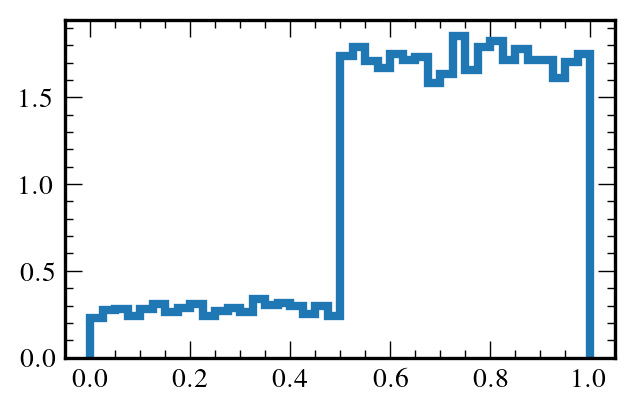

In [68]:
plt.hist(chain[:, -1], **hist_settings)
plt.show()

In [74]:
rel_model_freq, _ = np.histogram(chain[:, -1], bins = [0, 0.5, 1])
rel_model_freq

array([ 3794, 23431])

In [75]:
rel_model_freq[1]/rel_model_freq[0]

6.175803900896152